In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight 
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

1. Prétraitement des Données et Augmentation

In [26]:
base_data_dir = 'chest_xray/' 
train_dir = os.path.join(base_data_dir, 'train')
val_dir = os.path.join(base_data_dir, 'val')
test_dir = os.path.join(base_data_dir, 'test')

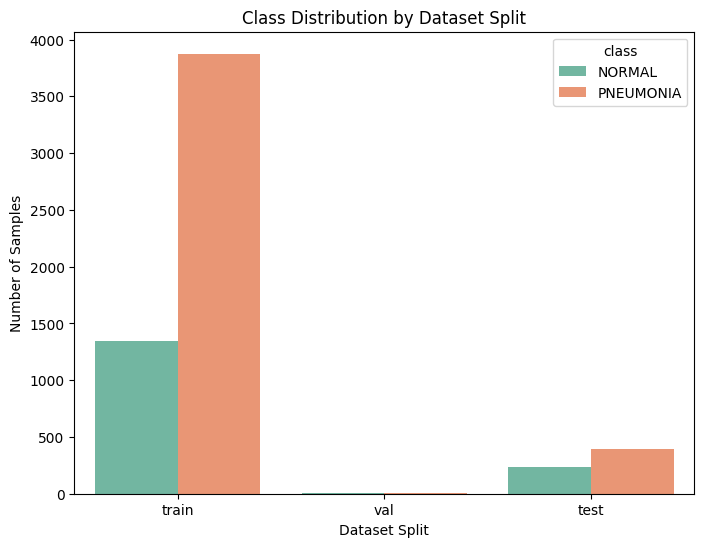

In [ ]:

# Collect class distributions from the generators
split_names = ['train', 'val', 'test']
generators = [train_generator, val_generator, test_generator]
data = []

for split_name, gen in zip(split_names, generators):
    class_counts = np.bincount(gen.classes)
    for class_idx, count in enumerate(class_counts):
        class_label = list(gen.class_indices.keys())[class_idx]
        data.append({'split': split_name, 'class': class_label, 'count': count})

# Create DataFrame
df_counts = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=df_counts, x='split', y='count', hue='class', palette='Set2')
plt.title('Class Distribution by Dataset Split')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset Split')
plt.show()


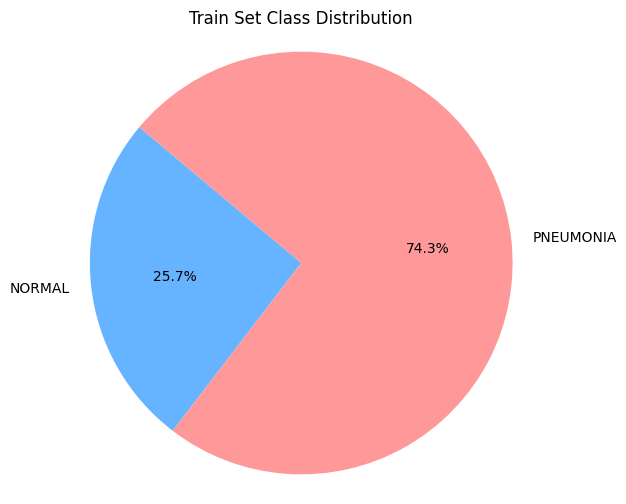

In [28]:
train_class_counts = np.bincount(train_generator.classes)
class_labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(6,6))
plt.pie(train_class_counts, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Train Set Class Distribution')
plt.axis('equal')
plt.show()


In [29]:
img_height, img_width = 128, 128
batch_size = 32
num_classes = 1

train_datagen = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=20,       
    width_shift_range=0.15,  
    height_shift_range=0.15, 
    shear_range=0.2,         
    zoom_range=0.2,          
    horizontal_flip=True,    
    fill_mode='nearest'      
)


val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Indices des classes:", train_generator.class_indices)


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Poids des classes calculés:", class_weights_dict)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Indices des classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Poids des classes calculés: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [30]:
print("\nVérification des classes ---")

if train_generator: # Vérifier si train_generator a été initialisé
    print("Indices des classes (train_generator):", train_generator.class_indices)
    
    unique_classes_train, counts_train = np.unique(train_generator.classes, return_counts=True)
    if len(unique_classes_train) == len(train_generator.class_indices):
        
        idx_to_class_name = {v: k for k, v in train_generator.class_indices.items()}
        class_counts_train_named = {idx_to_class_name[idx]: count for idx, count in zip(unique_classes_train, counts_train)}
        print("Nombre d'images par classe (entraînement):", class_counts_train_named)
    else:
        print("Compte des classes (entraînement, index):", dict(zip(unique_classes_train, counts_train)))

    if val_generator:
        unique_classes_val, counts_val = np.unique(val_generator.classes, return_counts=True)
        if len(unique_classes_val) == len(val_generator.class_indices):
            idx_to_class_name_val = {v: k for k, v in val_generator.class_indices.items()}
            class_counts_val_named = {idx_to_class_name_val[idx]: count for idx, count in zip(unique_classes_val, counts_val)}
            print("Nombre d'images par classe (validation):", class_counts_val_named)
        else:
            print("Compte des classes (validation, index):", dict(zip(unique_classes_val, counts_val)))
else:
    print("train_generator n'a pas été initialisé. Impossible de vérifier les classes.")


Vérification des classes ---
Indices des classes (train_generator): {'NORMAL': 0, 'PNEUMONIA': 1}
Nombre d'images par classe (entraînement): {'NORMAL': np.int64(1341), 'PNEUMONIA': np.int64(3875)}
Nombre d'images par classe (validation): {'NORMAL': np.int64(8), 'PNEUMONIA': np.int64(8)}


In [31]:
print("\nCalcul des poids de classe (ACTIVÉ) ---")

class_weight_dict = None 

if train_generator: 
    classes_train = train_generator.classes
    labels_unique_train = np.unique(classes_train)
    
    if len(labels_unique_train) > 1:
        class_weights_values = compute_class_weight(
            class_weight='balanced',
            classes=labels_unique_train,
            y=classes_train
        )
        class_weight_dict = dict(zip(labels_unique_train, class_weights_values))
        print("Poids de classe calculés pour l'entraînement:", class_weight_dict)
    else:
        print("Moins de deux classes trouvées dans train_generator. Les poids de classe ne sont pas calculés.")
else:
    print("train_generator non initialisé. Impossible de calculer les poids de classe.")




Calcul des poids de classe (ACTIVÉ) ---
Poids de classe calculés pour l'entraînement: {np.int32(0): np.float64(1.9448173005219984), np.int32(1): np.float64(0.6730322580645162)}




2. Définition du Modèle CNN

In [32]:
print("\nDéfinition du Modèle CNN (pour un BON modèle) ---")

model_binary = Sequential([
    Input(shape=(img_height, img_width, 3)), 

    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(), 
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)), 
    BatchNormalization(),
    Dropout(0.5), # Dropout important avant la couche de sortie
  
    Dense(num_classes, activation='sigmoid') 
])


optimizer = Adam(learning_rate=1e-4) 

model_binary.compile(optimizer=optimizer,
                     loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 

print("Résumé du modèle amélioré :")
model_binary.summary()


Définition du Modèle CNN (pour un BON modèle) ---


Résumé du modèle amélioré :


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,217 (16.36 MB)

 Trainable params: 4,288,513 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [36]:
print("\nEntraînement du Modèle")

epochs = 20 

history = None

if train_generator and val_generator and model_binary:
    if train_generator.samples == 0 or val_generator.samples == 0:
        print("ERREUR: Générateurs vides. Entraînement annulé.")
    else:
        early_stopping = EarlyStopping(
            monitor='val_accuracy', 
            patience=7,      
            verbose=1,
            restore_best_weights=True 
        )

        model_checkpoint = ModelCheckpoint(
            'best_chest_xray_model.keras', 
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, 
            patience=1, 
            verbose=1,
            min_lr=1e-6 
        )

        callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

        print(f"\nDébut de l'entraînement pour {epochs} époques (avec EarlyStopping)...")
        history = model_binary.fit(
            train_generator,
            steps_per_epoch=max(1, train_generator.samples // batch_size),
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=max(1, val_generator.samples // batch_size),
            class_weight=class_weight_dict if class_weight_dict else None, 
            callbacks=callbacks_list
        )
        
        # model_binary.save('final_chest_xray_model.keras')
        print("\nEntraînement terminé.")
else:
    print("Prérequis non remplis (générateurs ou modèle). L'entraînement est annulé.")


Entraînement du Modèle

Début de l'entraînement pour 20 époques (avec EarlyStopping)...
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8411 - loss: 0.6969 - precision_1: 0.9841 - recall_1: 0.8001
Epoch 1: val_loss improved from inf to 2.26125, saving model to best_chest_xray_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.8412 - loss: 0.6969 - precision_1: 0.9841 - recall_1: 0.8002 - val_accuracy: 0.5000 - val_loss: 2.2613 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8623 - loss: 0.6649 - precision_1: 0.9792 - recall_1: 0.8308
Epoch 2: val_loss improved from 2.26125 to 1.27226, saving model to best_chest_xray_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.8623 - loss: 0.6649 - precision_1: 0.9792 - recall_1: 0.8309 - val_accuracy: 0.5625 - val_loss: 1.2723 - val_precision_1: 0.5333 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05

4. Évaluation du Modèle

In [ ]:
print("\nÉvaluation du Meilleur Modèle ---")

best_model_path = 'App/best_chest_xray_model.keras' 

if os.path.exists(best_model_path):
    
    try:
        loaded_model = tf.keras.models.load_model(best_model_path)
    except ValueError as e:
        print(f"Erreur lors du chargement du modèle, tentative avec custom_objects pour les métriques: {e}")
        loaded_model = tf.keras.models.load_model(
            best_model_path,
            custom_objects={
                'Precision': tf.keras.metrics.Precision,
                'Recall': tf.keras.metrics.Recall
            }
        )
    print(f"Meilleur modèle '{best_model_path}' chargé pour évaluation.")

    if test_generator:
        if test_generator.samples == 0:
            print("ERREUR: test_generator vide. Évaluation annulée.")
        else:
            print("\nÉvaluation du modèle sur l'ensemble de test:")
            eval_results = loaded_model.evaluate(
                test_generator,
                steps=max(1, test_generator.samples // batch_size),
                verbose=1
            )

            for metric_name, value in zip(loaded_model.metrics_names, eval_results):
                print(f"Test {metric_name}: {value:.4f}")

            print("\nPrédictions sur l'ensemble de test:")
            y_pred_probs = loaded_model.predict(test_generator, verbose=1)
            y_pred = (y_pred_probs > 0.5).astype(int).flatten() 
            y_true = test_generator.classes 

            if len(y_true) == len(y_pred) and len(y_true) > 0:
                print("\nMatrice de Confusion:")
                print(confusion_matrix(y_true, y_pred))
                
                print("\nRapport de Classification:")
                target_names = [k for k, v in sorted(test_generator.class_indices.items(), key=lambda item: item[1])]
                print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
            else:
                print("Problème avec les tailles de y_true/y_pred ou données de test vides.")
    else:
        print("test_generator non initialisé. Évaluation annulée.")
else:
    print(f"Le fichier du meilleur modèle '{best_model_path}' n'a pas été trouvé. "
          "Assurez-vous que l'entraînement a eu lieu et a sauvegardé un modèle.")


Évaluation du Meilleur Modèle ---
Meilleur modèle 'best_chest_xray_model.keras' chargé pour évaluation.

Évaluation du modèle sur l'ensemble de test:
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step - accuracy: 0.8665 - loss: 0.6867 - precision_1: 0.5109 - recall_1: 0.5437
Test loss: 0.7874
Test compile_metrics: 0.8503

Prédictions sur l'ensemble de test:
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step

Matrice de Confusion:
[[202  32]
 [ 62 328]]

Rapport de Classification:
              precision    recall  f1-score   support

      NORMAL       0.77      0.86      0.81       234
   PNEUMONIA       0.91      0.84      0.87       390

    accuracy                           0.85       624
   macro avg       0.84      0.85      0.84       624
weighted avg       0.86      0.85      0.85       624



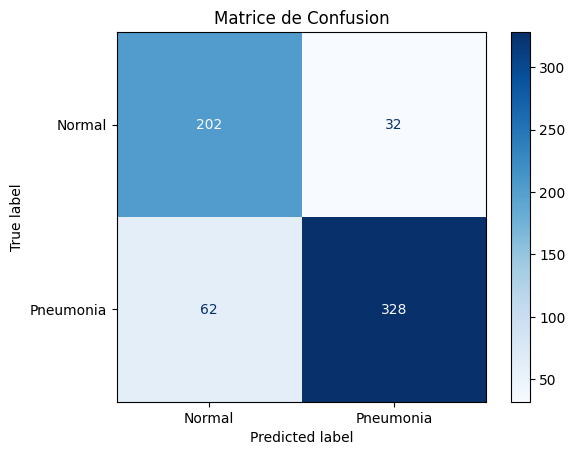

In [ ]:
if 'y_pred_probs' in locals() and 'y_true' in locals():
    y_pred = (y_pred_probs > 0.5).astype("int32")  
    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Matrice de Confusion")
    plt.grid(False)
    plt.show()
else:
    print("error.")



Affichage de l'historique d'entraînement ---


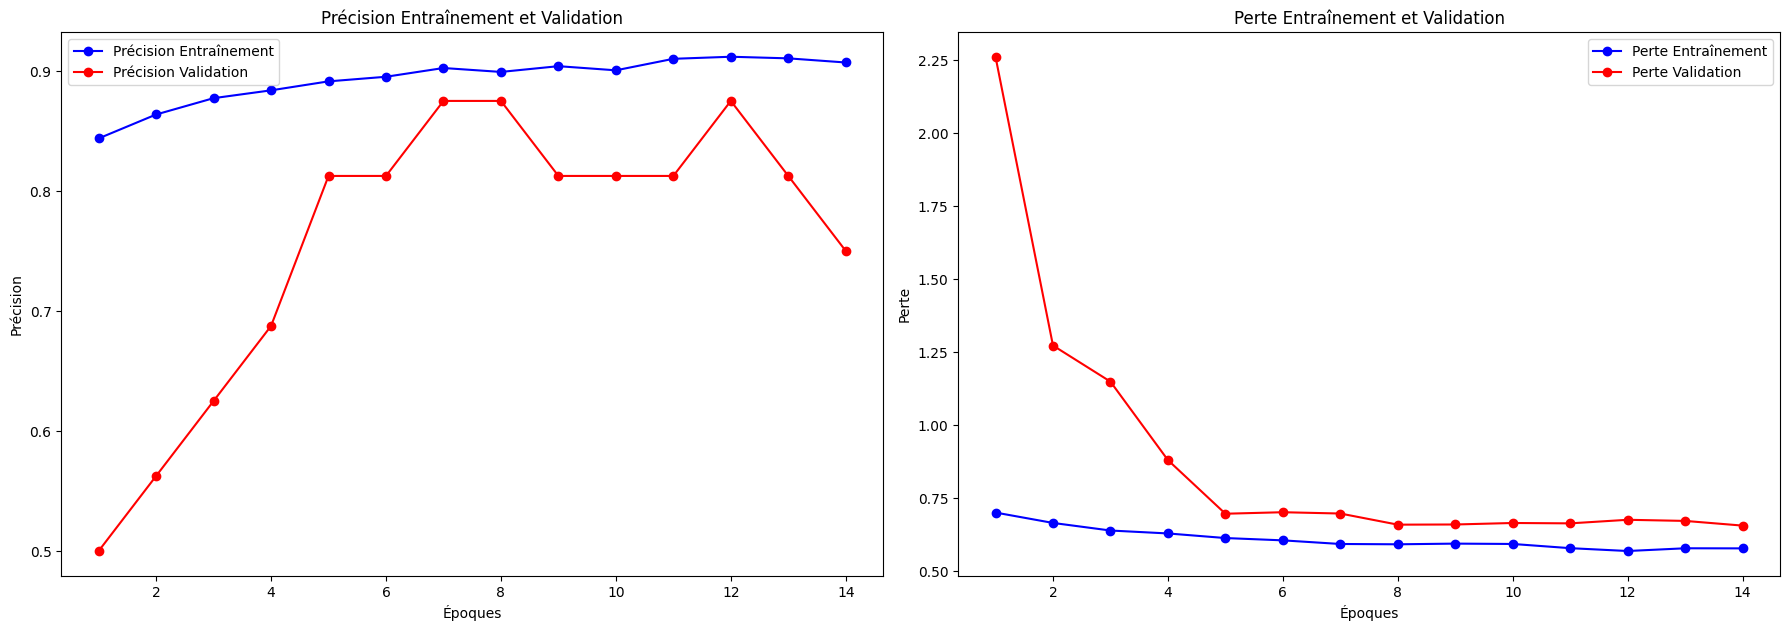

In [39]:
print("\nAffichage de l'historique d'entraînement ---")

if history and history.history: 
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss_hist = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    
    precision_hist = history.history.get('precision') 
    val_precision_hist = history.history.get('val_precision')
    
    recall_hist = history.history.get('recall') 
    val_recall_hist = history.history.get('val_recall')

    epochs_ran = range(1, len(acc) + 1) if acc else []

    if epochs_ran:
        plt.figure(figsize=(18, 12))

        
        plt.subplot(2, 2, 1)
        plt.plot(epochs_ran, acc, 'bo-', label='Précision Entraînement')
        plt.plot(epochs_ran, val_acc, 'ro-', label='Précision Validation')
        plt.title('Précision Entraînement et Validation')
        plt.xlabel('Époques')
        plt.ylabel('Précision')
        plt.legend()

        
        plt.subplot(2, 2, 2)
        plt.plot(epochs_ran, loss_hist, 'bo-', label='Perte Entraînement')
        plt.plot(epochs_ran, val_loss, 'ro-', label='Perte Validation')
        plt.title('Perte Entraînement et Validation')
        plt.xlabel('Époques')
        plt.ylabel('Perte')
        plt.legend()

        
        if precision_hist and val_precision_hist:
            plt.subplot(2, 2, 3)
            plt.plot(epochs_ran, precision_hist, 'go-', label='Precision Entraînement')
            plt.plot(epochs_ran, val_precision_hist, 'mo-', label='Precision Validation')
            plt.title('Métrique Precision Entraînement et Validation')
            plt.xlabel('Époques')
            plt.ylabel('Precision')
            plt.legend()

        
        if recall_hist and val_recall_hist:
            plt.subplot(2, 2, 4)
            plt.plot(epochs_ran, recall_hist, 'co-', label='Recall Entraînement')
            plt.plot(epochs_ran, val_recall_hist, 'yo-', label='Recall Validation')
            plt.title('Métrique Recall Entraînement et Validation')
            plt.xlabel('Époques')
            plt.ylabel('Recall')
            plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Pas assez de données d'historique pour afficher les graphiques.")
else:
    print("L'objet 'history' n'existe pas ou est vide. L'entraînement n'a peut-être pas eu lieu.")

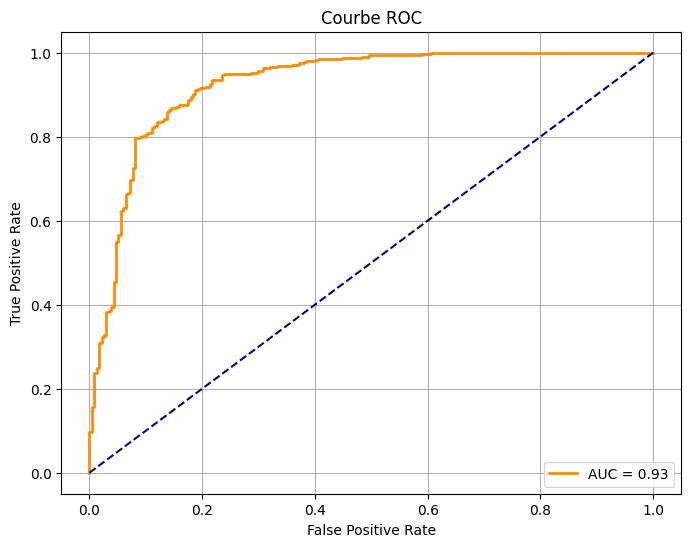

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
print("Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))


Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.77      0.86      0.81       234
   Pneumonia       0.91      0.84      0.87       390

    accuracy                           0.85       624
   macro avg       0.84      0.85      0.84       624
weighted avg       0.86      0.85      0.85       624



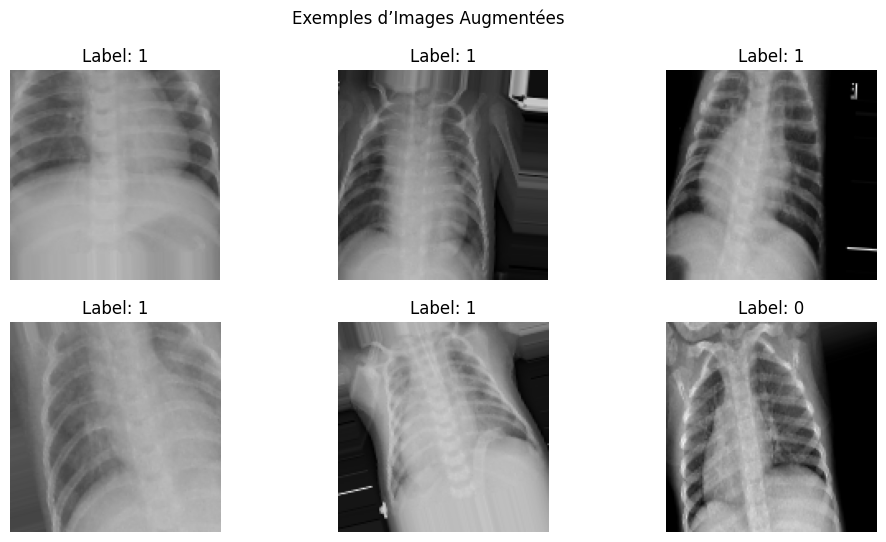

In [ ]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {int(y_batch[i])}")
    plt.axis('off')
plt.suptitle("Exemples d’Images Augmentées")
plt.show()


5. Réaliser des Prédictions sur de Nouvelles Images


--- CELLULE 9: Prédiction sur une seule image (avec le BON modèle) ---
Modèle 'best_chest_xray_model.keras' chargé pour prédiction unique.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
L'image 'IM-0001-0001.jpeg' est prédite comme: NORMAL avec une confiance de: 0.0007


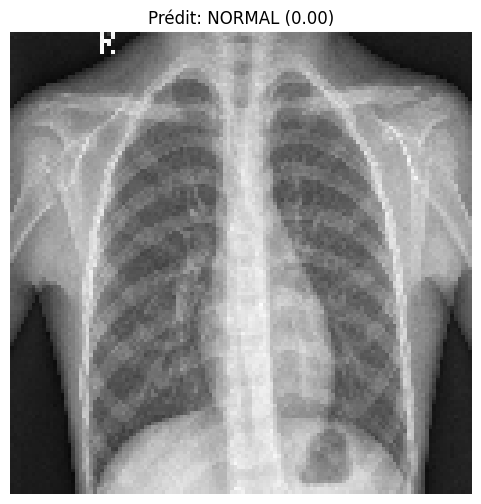

In [43]:
print("\n--- CELLULE 9: Prédiction sur une seule image (avec le BON modèle) ---")

def predict_single_image_good_model(model, img_path, img_height, img_width):
    try:
        
        img = tf.keras.preprocessing.image.load_img(
            img_path, 
            target_size=(img_height, img_width),
            color_mode='rgb' 
        )
    except FileNotFoundError:
        print(f"ERREUR: Le fichier image '{img_path}' n'a pas été trouvé.")
        return "ERREUR", 0.0, None 
    except Exception as e:
        print(f"ERREUR lors du chargement de l'image '{img_path}': {e}")
        return "ERREUR", 0.0, None

    # Convertit l'image en tableau NumPy.
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Ajoute une dimension de lot (batch dimension).
    img_array_expanded = np.expand_dims(img_array, axis=0)
   
    # Normalise les pixels (ESSENTIEL - doit correspondre à l'entraînement).
    img_array_processed = img_array_expanded / 255.0

    # Prédiction
    prediction_prob = model.predict(img_array_processed)[0][0] 
   
    # Convertit la probabilité en une classe binaire.
    if prediction_prob > 0.5:
        predicted_label = "PNEUMONIA"
    else:
        predicted_label = "NORMAL"
        
    return predicted_label, prediction_prob, img_array # Renvoyer l'array de l'image pour affichage

# Charger le meilleur modèle entraîné.
best_model_path_single_pred = 'best_chest_xray_model.keras'

if os.path.exists(best_model_path_single_pred):
    try:
        loaded_model_single_pred = tf.keras.models.load_model(best_model_path_single_pred)
    except ValueError: # Tentative avec custom_objects si les métriques posent problème
         loaded_model_single_pred = tf.keras.models.load_model(
            best_model_path_single_pred,
            custom_objects={
                'Precision': tf.keras.metrics.Precision,
                'Recall': tf.keras.metrics.Recall
            }
        )
    print(f"Modèle '{best_model_path_single_pred}' chargé pour prédiction unique.")

    example_image_path = os.path.join(test_dir, 'NORMAL', 'IM-0001-0001.jpeg') # Exemple
    

    if not os.path.exists(example_image_path):
        print(f"AVERTISSEMENT: L'image d'exemple '{example_image_path}' n'existe pas. "
              "La prédiction sur une seule image sera sautée ou échouera.")


    predicted_class, confidence, img_data_for_plot = predict_single_image_good_model(
        loaded_model_single_pred,
        example_image_path,
        img_height,
        img_width
    )

    if predicted_class != "ERREUR":
        print(f"L'image '{os.path.basename(example_image_path)}' est prédite comme: {predicted_class} avec une confiance de: {confidence:.4f}")
        
        # Afficher l'image avec sa prédiction
        plt.figure(figsize=(6,6))
        plt.imshow(img_data_for_plot.astype('uint8')) 
        plt.title(f"Prédit: {predicted_class} ({confidence:.2f})")
        plt.axis('off')
        plt.show()

else:
    print(f"Le fichier du meilleur modèle '{best_model_path_single_pred}' n'a pas été trouvé pour la prédiction.")